In [1]:
%matplotlib inline

import struct
import numpy
# Bigger fontsize is better *_*
from matplotlib import pyplot
pyplot.rcParams.update({'font.size': 18})
from matplotlib import pyplot
from scipy.optimize import fsolve

from amuse.units import units
from amuse.units import constants
from amuse.units import nbody_system
from amuse.units.quantities import new_quantity
from amuse.units.quantities import VectorQuantity
from amuse import datamodel
from amuse.community.gadget2.interface import Gadget2
from amuse.io import read_set_from_file, write_set_to_file
import amuse.plot as amuse_plot

def amuse_nth_root(quant, n):
    # Simply telling AMUSE quant**(1./3) breaks the units :-(
    return new_quantity((quant.number)**(1./n), (quant.unit ** (1./n)).to_simple_form())

In [42]:
# AMUSE built-in GADGET-2 parser does not work and the code looks too complicated for me to fix it
# cluster = read_set_from_file(filename, format='gadget', is_initial_conditions_format=True)
# Throws "error: unpack requires a string argument of length 204" in reading the header
# So here we have our own implementation to parse the IC file

# First we simply parse the dataset block my block in a very inefficient way
# Further on I have implemented a slightly more elegant parser, which needs further improvement
def read_toycluster_into_dataset(filename='IC_single_0'):
    # Lisa, Masterkamer, mbp are all little endian
    # Donnert (2014), Donnert (2016) in prep Toycluster provides gadget type 2 binary file; is IC file

    f = open(filename, 'rb')
    blocklength = numpy.zeros(1, dtype=numpy.uint32)
    
    # First block: header (new in Gadget2 filetype)
    blocklength = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength

    blockid = numpy.fromfile(f, dtype='byte', count=blocklength)
    print blockid, "".join([chr(abs(c)) for c in blockid])
    # H E A D backspace start-of-heading null null
    # print "".join([chr(c) for c in blockid])
    
    blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength_end
    if blocklength != blocklength_end:
        print 'error: blocklengths differ'
        
    blocklength = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength
    
    # Next block: "readu,1,npart,massarr,time,redshift,flag_sfr,flag_feedback,npartTotal,la"
    npart = numpy.fromfile(f, dtype=numpy.uint32, count=6)    
    massarr = numpy.fromfile(f, dtype=numpy.float64, count=6)
    time = numpy.fromfile(f, dtype=numpy.float64, count=1)
    redshift = numpy.fromfile(f, dtype=numpy.float64, count=1)
    flag_sfr = numpy.fromfile(f, dtype=numpy.int32, count=1)  # unused in public version of GADGET-2
    flag_feedback = numpy.fromfile(f, dtype=numpy.int32, count=1)  # unused
    npartTotal = numpy.fromfile(f, dtype=numpy.int32, count=6)
    flag_cooling = numpy.fromfile(f, dtype=numpy.int32, count=1)
    numFiles = numpy.fromfile(f, dtype=numpy.int32, count=1)
    boxSize = numpy.fromfile(f, dtype=numpy.float64, count=1)
    omega0 = numpy.fromfile(f, dtype=numpy.float64, count=1)
    omegalambda = numpy.fromfile(f, dtype=numpy.float64, count=1)
    hubbleParam = numpy.fromfile(f, dtype=numpy.float64, count=1)
    flag_age = numpy.fromfile(f, dtype=numpy.int32, count=1)  # unused
    flag_metals = numpy.fromfile(f, dtype=numpy.int32, count=1)  # unused
    numpart_total_hw = numpy.fromfile(f, dtype=numpy.int32, count=6)  # unused
    
    bytesleft = 256-6*4 - 6*8 - 8 - 8 - 2*4-6*4 - 4 - 4 - 8 - 8 - 8 - 8 - 4 - 4 - 6*4
    la = numpy.fromfile(f, dtype=numpy.uint16, count=bytesleft/2)
    
    print "npart", npart
    print "massarr", massarr
    print "time", time
    print "redshift", redshift
    print "flag_sfr", flag_sfr
    print "flag_feedback", flag_feedback
    print "npartTotal", npartTotal
    print "flag_cooling", flag_cooling
    print "numFiles", numFiles
    print "boxSize", boxSize
    print "omega0", omega0
    print "omegalambda", omegalambda
    print "hubbleParam", hubbleParam
    print "flag_age", flag_age
    print "flag_metals", flag_metals
    print "la", la
    
    blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength_end
    if not numpy.equal(blocklength, blocklength_end):
        print 'error: blocklengths differ'

    # Third block: POS
    blocklength = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength
    
    pos_header = numpy.fromfile(f, dtype='byte', count=blocklength)
    print pos_header, "".join([chr(abs(c)) for c in pos_header])
    # [ 80  79  83  32   8 -97  36   0] = P O S escape backspace -97 $ null
    
    blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength_end
    if not numpy.equal(blocklength, blocklength_end):
        print 'error: blocklengths differ'
    
    # Fourth block: the actual positions
    blocklength = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength
    
    N = numpy.sum(npart)
    
    pos = numpy.empty((3, N), dtype='float32')
    tmppos = numpy.fromfile(f, dtype='float32', count=pos.size)
    pos = numpy.transpose(numpy.reshape(tmppos, pos.shape))
    
    print pos
#     x = pos[:,0]
#     y = pos[:,1]
#     z = pos[:,2]
#     print x[0:3], y[0:3], z[0:3]
#     print x[-3:], y[-3:], z[-3:]
    
#     r = numpy.sqrt(x**2+y**2+z**2)
#     pyplot.figure(figsize=(12,9))
#     pyplot.hist(r, bins=int(numpy.sqrt(len(r))))
    
#     pyplot.figure(figsize=(12,9))
#     pyplot.scatter(x,y)
#     pyplot.figure(figsize=(12,9))
#     pyplot.scatter(x,z)

    
    blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength_end
    if not numpy.equal(blocklength, blocklength_end):
        print 'error: blocklengths differ'
        
    # Fifth block: VEL
    blocklength = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength
    
    vel_header = numpy.fromfile(f, dtype='byte', count=blocklength)
    print vel_header, "".join([chr(abs(c)) for c in vel_header])
    # [ 86  69  76  32   8 -97  36   0] = V E L escape backspace -97 $ null
    
    blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength_end
    if not numpy.equal(blocklength, blocklength_end):
        print 'error: blocklengths differ'
    
    # Sixth block: the actual velocities
    blocklength = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength
    
    N = numpy.sum(npart)
    
    vel = numpy.empty((3, N), dtype='float32')
    tmpvel = numpy.fromfile(f, dtype='float32', count=vel.size)
    vel = numpy.transpose(numpy.reshape(tmpvel, vel.shape))
    
    print vel
    
    blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength_end
    if not numpy.equal(blocklength, blocklength_end):
        print 'error: blocklengths differ'
        
    # Seventh block: ID
    blocklength = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength
    
    ids_header = numpy.fromfile(f, dtype='byte', count=blocklength)
    print ids_header, "".join([chr(abs(c)) for c in ids_header])
    # [73 68 32 32  8 53 12  0] = I D backspace backspace 5 FF null

    blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength_end
    if not numpy.equal(blocklength, blocklength_end):
        print 'error: blocklengths differ'

    # Eigth block: actual IDs
    blocklength = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength
    
    ids = numpy.fromfile(f, dtype='uint32', count=N)
    
    print ids
    
    blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
    print blocklength_end
    if not numpy.equal(blocklength, blocklength_end):
        print 'error: blocklengths differ'
        
    # TODO: test this, because the binary file used to test does not have individual masses
    # If the particles have individual masses the next block contains the masses
    ind = numpy.intersect1d(numpy.nonzero(npart), numpy.where(massarr == 0.0))
    Nwithmass = numpy.sum(npart[ind])
    if Nwithmass > 0:
        print "Warning: this code is untested, check that the output makes sense!"
        print "particles have individual mass"
        
        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        mass_header = numpy.fromfile(f, dtype='byte', count=blocklength)
        print mass_header, "".join([chr(abs(c)) for c in mass_header])
        
        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'    
        
        
        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        mass = numpy.fromfile(f, dtype='float32', count=Nwithmass)
        print mass

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'
            
        print "TODO: place correct mass at correct particle"
        
    Ngas = npart[0]
    if Ngas > 0:
        # Internal energy
        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        u_header = numpy.fromfile(f, dtype='byte', count=blocklength)
        print u_header, "".join([chr(abs(c)) for c in u_header])
        
        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'    
        
        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        u = numpy.fromfile(f, dtype='float32', count=Ngas)
        print u

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'
            
        # Density
        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        rho_header = numpy.fromfile(f, dtype='byte', count=blocklength)
        print rho_header, "".join([chr(abs(c)) for c in rho_header])
        
        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'    
        
        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        rho = numpy.fromfile(f, dtype='float32', count=Ngas)
        print rho

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'
    
        # HSML: smoothing length
        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        hsml_header = numpy.fromfile(f, dtype='byte', count=blocklength)
        print hsml_header, "".join([chr(abs(c)) for c in hsml_header])

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'

        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        hsml = numpy.fromfile(f, dtype='float32', count=Ngas)
        print hsml

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'
            
        # U: internal energy
        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        u_header = numpy.fromfile(f, dtype='byte', count=blocklength)
        print u_header, "".join([chr(abs(c)) for c in u_header])

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'

        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        u = numpy.fromfile(f, dtype='float32', count=Ngas)
        print u

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'
    
    
    # Potential
    has_potential = False
    if has_potential:
        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        hsml_header = numpy.fromfile(f, dtype='byte', count=blocklength)
        print hsml_header, "".join([chr(abs(c)) for c in hsml_header])

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'

        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        hsml = numpy.fromfile(f, dtype='float32', count=Ngas)
        print hsml

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'
    # Acceleration
    has_acceleration = False
    if has_acceleration:
        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        hsml_header = numpy.fromfile(f, dtype='byte', count=blocklength)
        print hsml_header, "".join([chr(abs(c)) for c in hsml_header])

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'

        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        hsml = numpy.fromfile(f, dtype='float32', count=Ngas)
        print hsml

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'    
    # RateOfChangeOfEntropy
    has_endt = False
    if has_endt:
        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        hsml_header = numpy.fromfile(f, dtype='byte', count=blocklength)
        print hsml_header, "".join([chr(abs(c)) for c in hsml_header])

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'

        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        hsml = numpy.fromfile(f, dtype='float32', count=Ngas)
        print hsml

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'
    # TimeStep
    has_tstp = False
    if has_tstp:
        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        hsml_header = numpy.fromfile(f, dtype='byte', count=blocklength)
        print hsml_header, "".join([chr(abs(c)) for c in hsml_header])

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'

        blocklength = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength

        hsml = numpy.fromfile(f, dtype='float32', count=Ngas)
        print hsml

        blocklength_end = numpy.fromfile(f, dtype='uint32', count=1)
        print blocklength_end
        if not numpy.equal(blocklength, blocklength_end):
            print 'error: blocklengths differ'
    f.close()

cluster = read_toycluster_into_dataset()

[8]
[72 69 65 68  8  1  0  0] HEAD  
[8]
[256]
npart [100000 100000      0      0      0      0]
massarr [ 0.19704275  1.39625564  0.          0.          0.          0.        ]
time [ 0.]
redshift [ 0.]
flag_sfr [0]
flag_feedback [0]
npartTotal [100000 100000      0      0      0      0]
flag_cooling [0]
numFiles [1]
boxSize [ 13923.]
omega0 [ 1.]
omegalambda [ 0.7]
hubbleParam [ 0.7]
flag_age [0]
flag_metals [0]
la [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[256]
[8]
[ 80  79  83  32   8 -97  36   0] POS a$ 
[8]
[2400000]
[[  399.640625    7502.04199219  9586.3828125 ]
 [  511.71566772  7426.31201172  9011.42675781]
 [ 2640.60571289  7311.66650391  2804.18603516]
 ..., 
 [ 7481.83056641  7148.17529297  5393.72949219]
 [ 7422.6875      8061.10644531  6467.15673828]
 [ 7309.61914062  4916.25        5318.10351562]]
[2400000]
[8]
[ 86  69  76  32   8 -97  36   0] VEL a$ 
[8]
[2400000]
[[    0.             0.          1076.43164062]
 [    0.             0.     

NameError: name 'pos' is not defined

In [3]:
class Gadget2BinaryF77UnformattedType2Parser(object):
    """ Parse unformatted Fortran 77 binary file written by Gadget2: type 2 output.
    
        Based on Springel's read_snapshot_single.pro, but in Python.
        Useful documentation for porting script to Python:
            - http://www.harrisgeospatial.com/docs/fltarr.html
            - http://www.harrisgeospatial.com/docs/idl_ese_datatypes.html
        
        Tested only with Dr. Donnert's Toycluster output (IC-file)"""
    
    def __init__(self, filename='IC_single_0'):
        
        self.f = open(filename, 'rb')
        self.blocklength = numpy.zeros(1, dtype=numpy.uint32)
        
        length, content = self.read_block()
        if self.get_blockname(content) == "HEAD":
            self.read_header()
            
        self.N = numpy.sum(self.npart)
        self.Ngas = self.npart[0]
        self.Ndm = self.npart[1]

        # TODO: shove this into a loop, e.g. while end of file not is reached
            # read block, check blockname, call correct function to parse block
            # now this is in the order the blocks were written but other gadget2 files might differ.
        length, content = self.read_block()
        #  TODO: just read N bytes because we know the blocklength as it is written in the file
            # afterwards we can get the correct numbers because we know the datatype for a given attribute
        if self.get_blockname(content) == "POS":
            length, content = self.read_block()
            # https://stackoverflow.com/questions/23377274
            self.pos = numpy.empty((self.N, 3), dtype='float32')
            tmppos = numpy.frombuffer(content, dtype='float32', count=self.pos.size)
            self.pos = numpy.reshape(tmppos, self.pos.shape)
 
        length, content = self.read_block()
        if self.get_blockname(content) == "VEL":
            length, content = self.read_block()
            self.vel = numpy.empty((self.N, 3), dtype='float32')
            tmpvel = numpy.frombuffer(content, dtype='float32', count=self.vel.size)
            self.vel = numpy.reshape(tmpvel, self.vel.shape)
        
        length, content = self.read_block()
        if self.get_blockname(content) == "ID":
            length, content = self.read_block()
            self.ids = numpy.frombuffer(content, dtype='uint32', count=self.N)
        
        # TODO: test this, because the binary file used to test does not have individual masses
        # If the particles have individual masses the next block contains the masses
        ind = numpy.intersect1d(numpy.nonzero(self.npart), numpy.where(self.massarr == 0.0))
        self.Nwithmass = numpy.sum(self.npart[ind])
        
        if self.Nwithmass > 0:
            print "Warning: this code is untested, check that the output makes sense!"
            print "particles have individual mass"
            length, content = self.read_block()
            if self.get_blockname(content) == "RHO":
                length, content = self.read_block()
                self.mass = numpy.frombuffer(content, dtype='float32', count=Nwithmass)
            print "TODO: place correct mass at correct particle, split flat array"
            

        if self.Ngas > 0:
            length, content = self.read_block()
            if self.get_blockname(content) == "RHO":
                length, content = self.read_block()
                self.rho = numpy.frombuffer(content, dtype='float32', count=self.Ngas)
            length, content = self.read_block()
            
            if self.get_blockname(content) == "RHOM":
                length, content = self.read_block()
                self.rhom = numpy.frombuffer(content, dtype='float32', count=self.Ngas)
        
            length, content = self.read_block()
            if self.get_blockname(content) == "HSML":
                length, content = self.read_block()
                self.hsml = numpy.frombuffer(content, dtype='float32', count=self.Ngas)
            
            length, content = self.read_block()
            if self.get_blockname(content) == "U":
                length, content = self.read_block()
                self.u = numpy.frombuffer(content, dtype='float32', count=self.Ngas)
             
        magnetic_field = True
        if magnetic_field:
            length, content = self.read_block()
            if self.get_blockname(content) == "BFLD":
                length, content = self.read_block()
                self.bfld = numpy.frombuffer(content, dtype='float32', count=self.Ngas)
        
        self.f.close()
    
    def read_block(self, fmt='byte'):
        # First block: header (new in Gadget2 filetype)
        length = numpy.fromfile(self.f, dtype=numpy.uint32, count=1)
        content = numpy.fromfile(self.f, dtype=fmt, count=length)
        end_length = numpy.fromfile(self.f, dtype=numpy.uint32, count=1)
        
        if end_length != length:
            print 'error: blocklengths differ'
            return None            
        return length, content
    
    def get_blockname(self, blockinfo):
        # TODO: this code could probably be written way more elegent but now it does what it's supposed to
        blockname = ""
        for c in blockinfo:
            if 65 <= c <= 90:
                blockname += chr(c)
            else:
                break
        return blockname
    
    def read_header(self):
        self.blocklength = numpy.fromfile(self.f, dtype='uint32', count=1)
        # print self.blocklength
        
        # Header block: "readu,1,npart,massarr,time,redshift,flag_sfr,flag_feedback,npartTotal,la"
        # TODO: This can be implemented in a single numpy fromfile statement using a dtype array
        self.npart = numpy.fromfile(self.f, dtype=numpy.uint32, count=6)    
        self.massarr = numpy.fromfile(self.f, dtype=numpy.float64, count=6)
        self.time = numpy.fromfile(self.f, dtype=numpy.float64, count=1)[0]
        self.redshift = numpy.fromfile(self.f, dtype=numpy.float64, count=1)[0]
        self.flag_sfr = numpy.fromfile(self.f, dtype=numpy.int32, count=1)[0]  # unused in public version of GADGET-2
        self.flag_feedback = numpy.fromfile(self.f, dtype=numpy.int32, count=1)[0]  # unused
        self.npartTotal = numpy.fromfile(self.f, dtype=numpy.int32, count=6)
        self.flag_cooling = numpy.fromfile(self.f, dtype=numpy.int32, count=1)[0]
        self.numFiles = numpy.fromfile(self.f, dtype=numpy.int32, count=1)[0]
        self.boxSize = numpy.fromfile(self.f, dtype=numpy.float64, count=1)[0]
        self.omega0 = numpy.fromfile(self.f, dtype=numpy.float64, count=1)[0]
        self.omegalambda = numpy.fromfile(self.f, dtype=numpy.float64, count=1)[0]
        self.hubbleParam = numpy.fromfile(self.f, dtype=numpy.float64, count=1)[0]
        self.flag_age = numpy.fromfile(self.f, dtype=numpy.int32, count=1)[0]  # unused
        self.flag_metals = numpy.fromfile(self.f, dtype=numpy.int32, count=1)[0]  # unused
        self.numpart_total_hw = numpy.fromfile(self.f, dtype=numpy.int32, count=6)  # unused

        bytesleft = 256-6*4 - 6*8 - 8 - 8 - 2*4-6*4 - 4 - 4 - 8 - 8 - 8 - 8 - 4 - 4 - 6*4
        self.la = numpy.fromfile(self.f, dtype=numpy.uint16, count=bytesleft/2)
        
        blocklength_end = numpy.fromfile(self.f, dtype='uint32', count=1)
        # print blocklength_end
        if self.blocklength != blocklength_end:
            print 'error: blocklengths differ'
        
    @property
    def str_header(self):
        tmp = "npart: \t\t" + str(self.npart) + "\n"
        tmp += "massarr: \t" + str(self.massarr) + "\n"
        tmp +=  "time: \t\t" + str(self.time) + "\n"
        tmp +=  "redshift: \t" + str(self.redshift) + "\n"
        tmp +=  "flag_sfr: \t" + str(self.flag_sfr) + "\n"
        tmp +=  "flag_feedback: \t" + str(self.flag_feedback) + "\n"
        tmp +=  "npartTotal: \t" + str(self.npartTotal) + "\n"
        tmp +=  "flag_cooling: \t" + str(self.flag_cooling) + "\n"
        tmp +=  "numFiles: \t" + str(self.numFiles) + "\n"
        tmp +=  "boxSize: \t" + str(self.boxSize) + "\n"
        tmp +=  "omega0: \t" + str(self.omega0) + "\n"
        tmp +=  "omegalambda: \t" + str(self.omegalambda) + "\n"
        tmp +=  "hubbleParam: \t" + str(self.hubbleParam) + "\n"
        tmp +=  "flag_age: \t" + str(self.flag_age) + "\n"
        tmp +=  "flag_metals: \t" + str(self.flag_metals) + "\n"
        tmp +=  "la: \t\t" + str(self.la) + "\n"
        
        return tmp
    
    @property
    def str_particles(self):
        tmp = "POS\n"
        tmp += str(self.pos)
        tmp += "\n\nVEL\n"
        tmp += str(self.vel)
        tmp += "\n\nID\n"
        tmp += str(self.ids)
        tmp += "\n\nRHO\n"
        tmp += str(self.rho)
        tmp += "\n\nRHOM\n"
        tmp += str(self.rhom)
        tmp += "\n\nHSML\n"
        tmp += str(self.hsml)
        tmp += "\n\nU\n"
        tmp += str(self.u)
        tmp += "\n\nBFLD\n"
        tmp += str(self.bfld)
        
        return tmp
    
    def __str__(self):
        tmp = self.str_header + "\n" + self.str_particles
        return tmp

In [35]:
class Cluster(object):
    def __init__(self, filename='IC_single_0'):
        self.raw_data = Gadget2BinaryF77UnformattedType2Parser(filename)
        # 1e10 because all masses are given in code units in cluster.par, which is set to 1e10 Msun
        self.M_gas = self.raw_data.Ngas * self.raw_data.massarr[0] * 1e10 | units.MSun
        self.M_dm = self.raw_data.Ndm * self.raw_data.massarr[1] * 1e10 | units.MSun
        self.gas, self.dm = self.place_ic_data_in_datamodel(self.raw_data)
        self.set_radius()
        self.set_dm_density()
        
    def set_radius(self):
        self.gas.r = amuse_nth_root((self.gas.x**2+self.gas.y**2+self.gas.z**2), 2).as_quantity_in(units.kpc)
        self.dm.r = amuse_nth_root((self.dm.x**2+self.dm.y**2+self.dm.z**2), 2).as_quantity_in(units.kpc)
        
    def set_dm_density(self):
        """ Dark Matter density radial profile rho(r). Given by Hernquist (1990) """
        self.a = 783.333 | units.kpc  # from output of running Toycluster
        rho_dm = self.M_dm/(2*numpy.pi) * self.a / (self.dm.r*(self.dm.r + self.a)**3)
        self.dm.density = rho_dm.as_quantity_in(units.g/units.cm**3)
    
    def place_ic_data_in_datamodel(self, ic_data):
        # Split position and velocity arrays up
        ic_data.pos = (ic_data.pos - ic_data.boxSize/2)  * ic_data.hubbleParam | units.kpc
        
        gaspos = ic_data.pos[0:ic_data.Ngas]
        dmpos = ic_data.pos[ic_data.Ngas:ic_data.N]
        gasvel = ic_data.vel[0:ic_data.Ngas] | units.kms
        dmvel = ic_data.vel[ic_data.Ngas:ic_data.N] | units.kms 
        gasids = ic_data.ids[0:ic_data.Ngas]
        dmids = ic_data.ids[ic_data.Ngas:ic_data.N]

        # Set up particle datamodel for gas and dm
        gas = datamodel.Particles(ic_data.Ngas)
        dm = datamodel.Particles(ic_data.Ndm)

        # Place pos, vel and ids in gas/dm datamodel
        gas.x = gaspos[:,0]
        gas.y = gaspos[:,1]
        gas.z = gaspos[:,2]
        dm.x = dmpos[:,0]
        dm.y = dmpos[:,1]
        dm.z = dmpos[:,2]

        gas.vx = gasvel[:,0]
        gas.vy = gasvel[:,1]
        gas.vz = gasvel[:,2]
        dm.vx = dmvel[:,0]
        dm.vy = dmvel[:,1]
        dm.vz = dmvel[:,2]
        
        gas.ids = gasids
        dm.ids = dmids

        # Place SPH properties in gas particles datamodel
        # 1e10 because all masses are given in code units in cluster.par, which is set to 1e10 Msun
        gas.density = ic_data.rho * 1e10 * ic_data.hubbleParam**(2) | (units.MSun / units.kpc**3)
        gas.density_model = ic_data.rhom * 1e10 * ic_data.hubbleParam**(2) | (units.MSun / units.kpc**3)
        # gas.density = ic_data.rho | (units.g / units.cm**3)
        # gas.density_model = ic_data.rhom  | (units.g / units.cm**3)
        gas.hsml = ic_data.hsml
        gas.u = ic_data.u | units.kms**2
        gas.B = ic_data.bfld
        
        return gas, dm

# Sanity checks

Alright, so now we have parsed the dataset in a way that works (although it could be done more elegant). Now we will do some sanity checks.

From Donnert (2014) we get the following.
- In Sec. 3: "The initial velocity of the gas particles is set to zero"
- In Sec. 3: "The velocity of the DM component is satisfied so the Hernquist DF, equation (5), is satisfied"
- In Sec. 3: "The clusters DM profile is sampled up to infinity"
- In Sec. 3: "The gas profile of one cluster is sampled to a maximal radius $R_{\rm max}$, which is half the box size"


In [36]:
cluster = Cluster()
Ngas = cluster.raw_data.npart[0]
Ndm = cluster.raw_data.npart[1]

# Histogram of radii

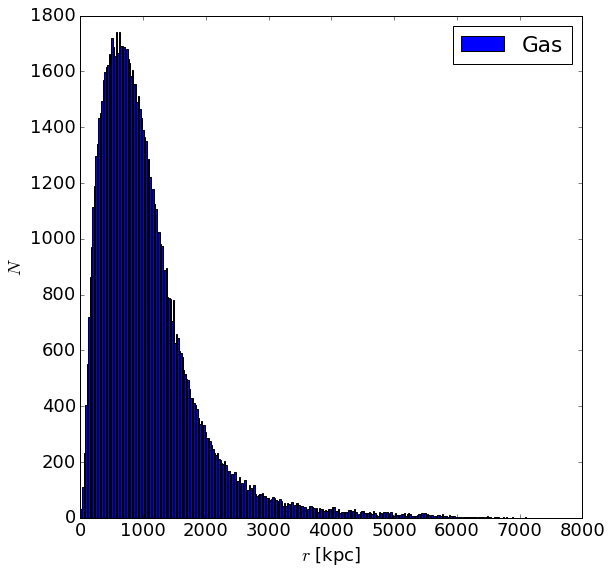

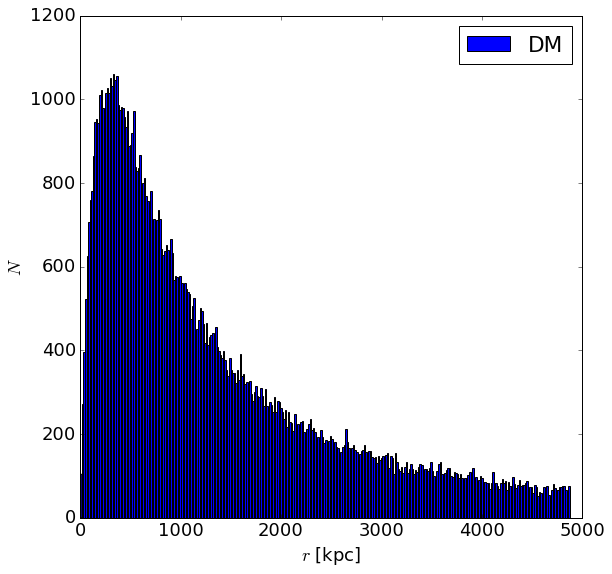

In [6]:
# Let's see what the radius of the gas and dm looks like
pyplot.figure(figsize=(9, 9))
amuse_plot.hist(cluster.gas.r, bins=int(numpy.sqrt(Ngas)), label="Gas")
amuse_plot.ylabel(r'$N$')
amuse_plot.xlabel(r'$r$')
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(9, 9))
amuse_plot.hist(cluster.dm.r, bins=int(numpy.sqrt(Ndm)), label="DM")
pyplot.legend()
amuse_plot.ylabel(r'$N$')
amuse_plot.xlabel(r'$r$')
pyplot.show()

Hmm these histograms confuse me. It seems that when I parse the IC dataset the DM is sampled to a radius of just under 5000 kpc with a very clear cut off. The gas is sampled to around 7000 kpc. The box size is 13923 kpc, so half of that is just under 7000 kpc.

Why is the DM cut off so sharply instead of running up to infinity? Could this be because I have set the mass ratio in the parameter file to zero such that only one cluster is created? 
TODO: check the Toycluster code for this feature

# Velocity distribution

In [7]:
# Check the velocities of the gas (should only be zero) and of the dm (should follow Hernquist DF)
for attr in ["vx", "vy", "vz"]:
    # NB, turn into numpy array using value_in method! VectorQuantity has no nonzero method
    v = getattr(cluster.gas, attr).value_in(units.kms)
    if len(v.nonzero()[0]) != 0:
        print "Error: gas {0} has nonzero values".format(attr)
    else:
        print "Passed: gas {0} only has nonzero values".format(attr)
    v = getattr(cluster.dm, attr).value_in(units.kms)
    if len(v.nonzero()[0]) == Ngas:
        print "Passed: dm {0} has no nonzero values".format(attr)
    else:
        print "Error: dm {0} has nonzero values".format(attr)

Passed: gas vx only has nonzero values
Passed: dm vx has no nonzero values
Passed: gas vy only has nonzero values
Passed: dm vy has no nonzero values
Passed: gas vz only has nonzero values
Passed: dm vz has no nonzero values


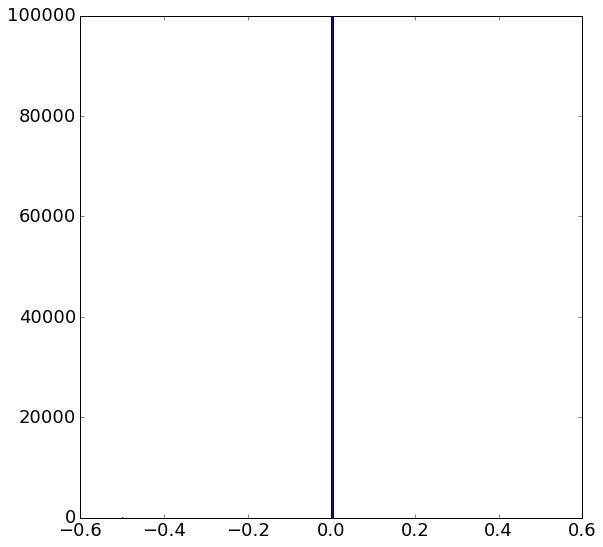

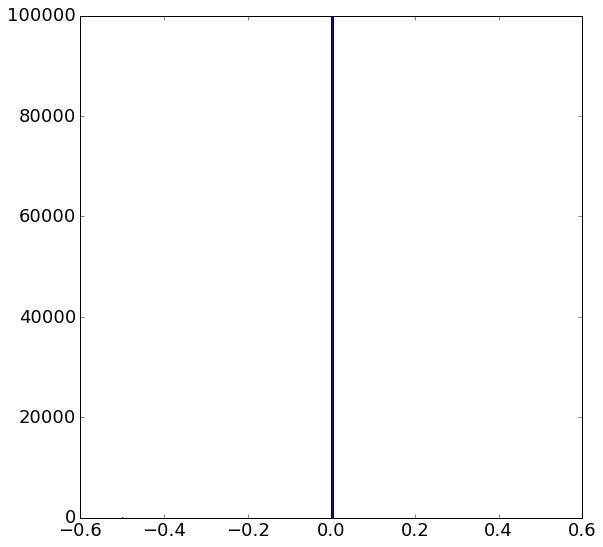

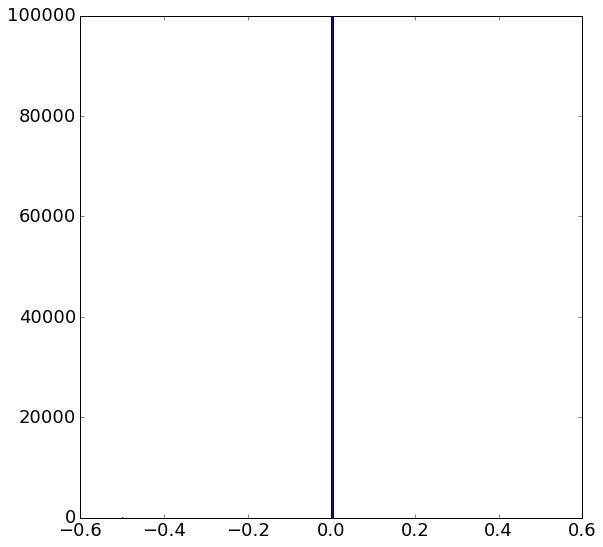

In [8]:
# Look at the gas velocity distribution (should only be zero)
pyplot.figure(figsize=(9,9))
amuse_plot.hist(cluster.gas.vx, bins=int(numpy.sqrt(Ngas)))
pyplot.show()

pyplot.figure(figsize=(9,9))
amuse_plot.hist(cluster.gas.vy, bins=int(numpy.sqrt(Ngas)))
pyplot.show()

pyplot.figure(figsize=(9,9))
amuse_plot.hist(cluster.gas.vz, bins=int(numpy.sqrt(Ngas)))
pyplot.show()

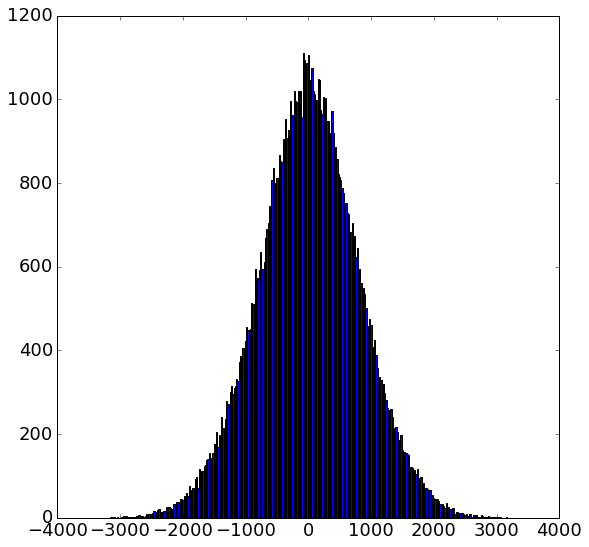

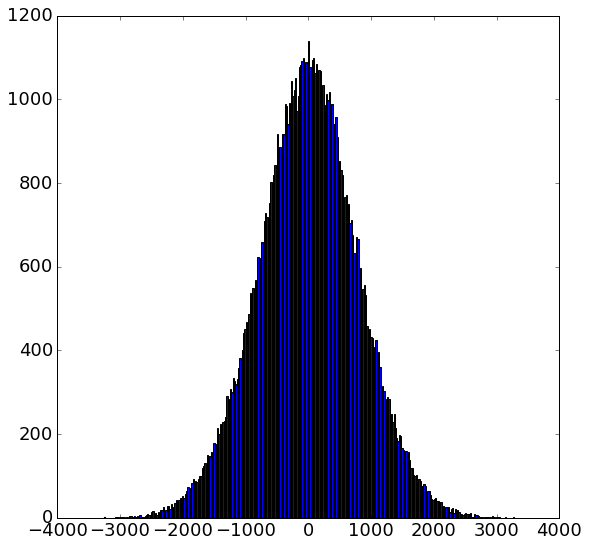

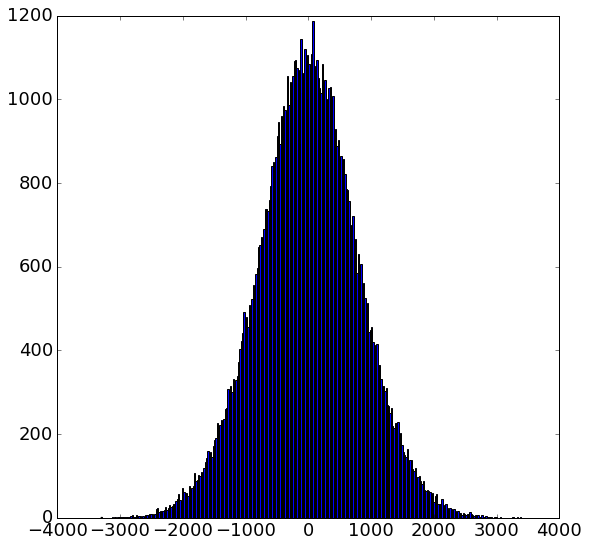

In [9]:
# Look at the dm velocity distribution (should follow Hernquist DF)

pyplot.figure(figsize=(9,9))
amuse_plot.hist(cluster.dm.vx, bins=int(numpy.sqrt(Ndm)))
pyplot.show()

pyplot.figure(figsize=(9,9))
amuse_plot.hist(cluster.dm.vy, bins=int(numpy.sqrt(Ndm)))
pyplot.show()

pyplot.figure(figsize=(9,9))
amuse_plot.hist(cluster.dm.vz, bins=int(numpy.sqrt(Ndm)))
pyplot.show()

### TODO: figure out how to plot the analytical velocity distribution to see if it matches

# Particle distribution

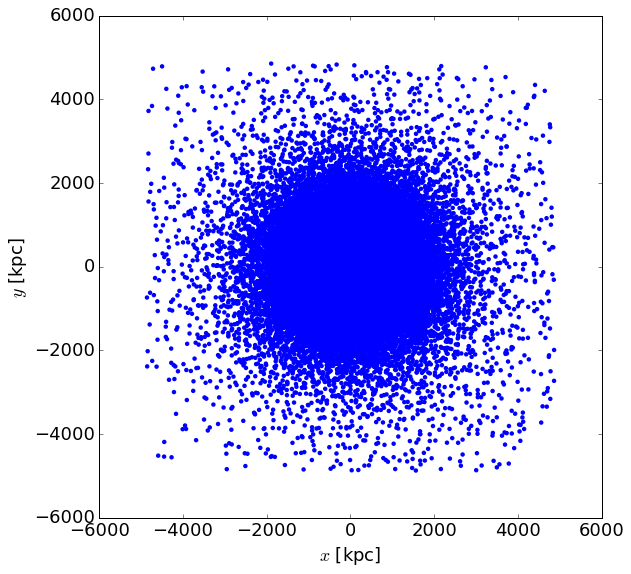

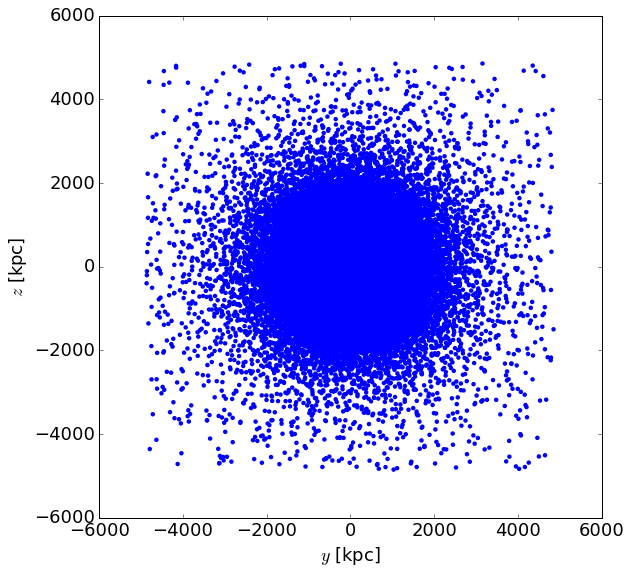

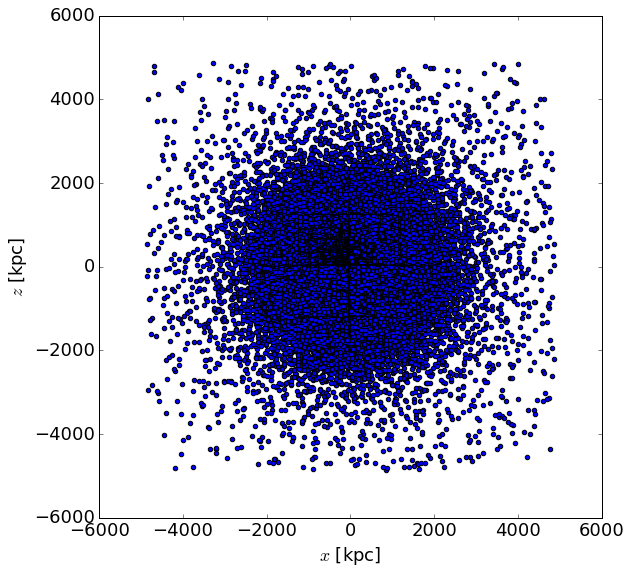

In [10]:
pyplot.figure(figsize=(9,9))
amuse_plot.scatter(cluster.gas.x, cluster.gas.y, edgecolor='none')
amuse_plot.xlabel(r'$x$')
amuse_plot.ylabel(r'$y$')
pyplot.show()

pyplot.figure(figsize=(9,9))
amuse_plot.scatter(cluster.gas.y, cluster.gas.z, edgecolor='none')
amuse_plot.xlabel(r'$y$')
amuse_plot.ylabel(r'$z$')
pyplot.show()

pyplot.figure(figsize=(9,9))
amuse_plot.scatter(cluster.gas.x, cluster.gas.z)
amuse_plot.xlabel(r'$x$')
amuse_plot.ylabel(r'$z$')
pyplot.show()

- Why does this plot seem to have features at the x=0, y=0, and z=0 line when the edgecolor is not set to none?
- Why do I see like a square around a circular thing? The circular thing makes sense.. it's the cluster gas (spherically symmetric), but the square thingy? 

Donnert (2014):
- "(...) We show how to sample a cluster merger beyond the virial radius to provide background gas and circumvent numerical problems with low-viscosity formulations of SPH. (...)"
- "(...) This provides a natural way to embed the observable inner region of the cluster in a background density and keep boundary effects away from the cluster centre. (...)"
- "(...) Nonetheless, the cold gas at large radii provides a background density for our simulation and the large box size keeps boundary effects away from the interesting cluster centre (...)". 

Also if I recall correctly Craig Sarazin mentioned when I spoke to him at November 17, 2015 that hydro simulations in general need a background density to avoid numerical problems. It sort of does seem to make sense that the gas has a background density, thus, particles surrounding the spherically symmetric gas...

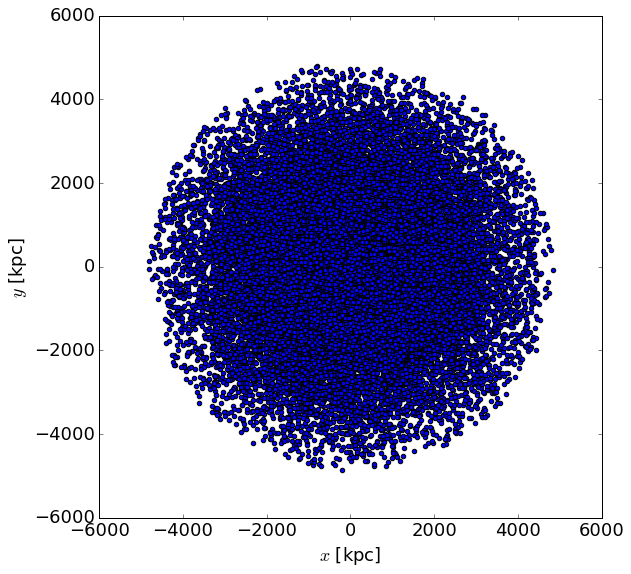

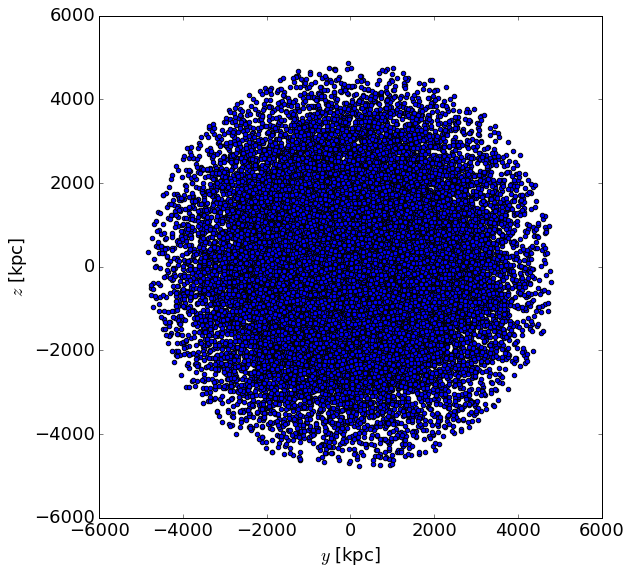

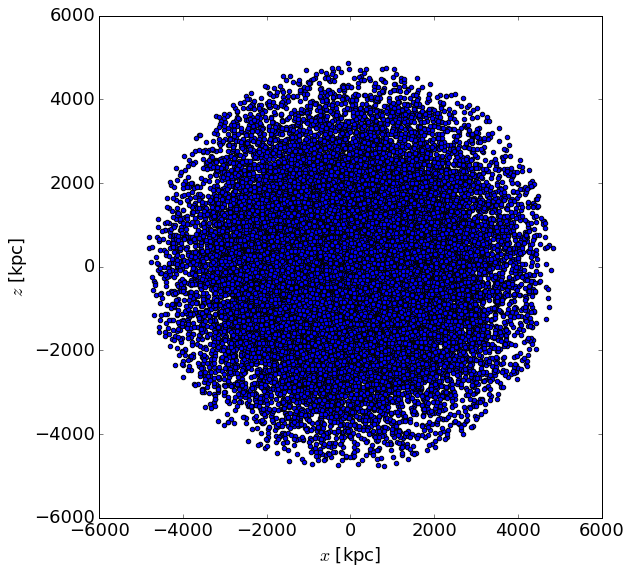

In [11]:
pyplot.figure(figsize=(9,9))
amuse_plot.scatter(cluster.dm.x, cluster.dm.y)
amuse_plot.xlabel(r'$x$')
amuse_plot.ylabel(r'$y$')
pyplot.show()

pyplot.figure(figsize=(9,9))
amuse_plot.scatter(cluster.dm.y, cluster.dm.z)
amuse_plot.xlabel(r'$y$')
amuse_plot.ylabel(r'$z$')
pyplot.show()

pyplot.figure(figsize=(9,9))
amuse_plot.scatter(cluster.dm.x, cluster.dm.z)
amuse_plot.xlabel(r'$x$')
amuse_plot.ylabel(r'$z$')
pyplot.show()

The above behaviour makes sense given the cut off in the histogram of the radius. However, it does not make sense as "the clusters DM profile is sampled up to infinity"?

## Now look at the density as a function of radius :-). See Figure 1 in Donnert (2014).

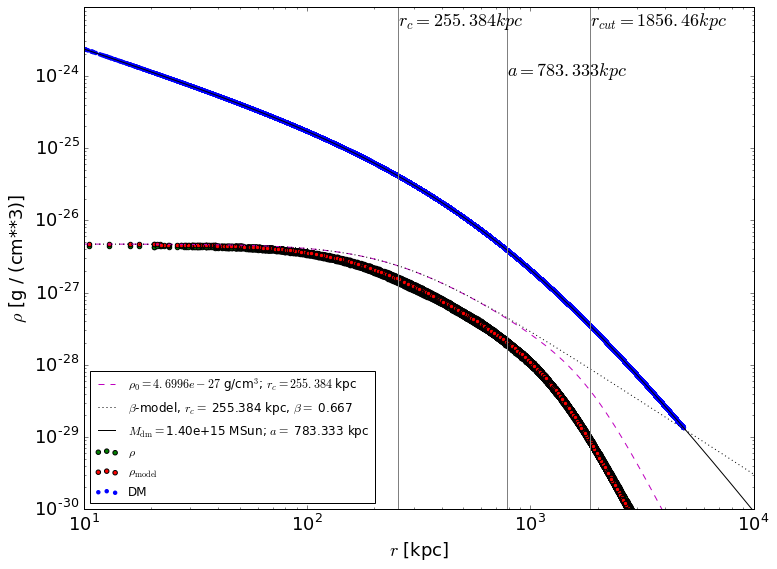

In [40]:
pyplot.figure(figsize=(12,9))
pyplot.gca().set_xscale('log')
pyplot.gca().set_yscale('log')

amuse_plot.scatter(cluster.gas.r, cluster.gas.density.as_quantity_in(units.g/units.cm**3), c='g', label=r'$\rho$')
amuse_plot.scatter(cluster.gas.r, cluster.gas.density_model.as_quantity_in(units.g/units.cm**3), c='r', label=r'$\rho_{\rm model}$')
amuse_plot.scatter(cluster.dm.r, cluster.dm.density.as_quantity_in(units.g/units.cm**3), c='b', edgecolor='none', label="DM")

# Analytical
r = VectorQuantity.arange(units.kpc(1), units.kpc(10000), units.parsec(100))
beta = 2./3  # Mastropietro & Burkert (2008)
r_c = 255.384 | units.kpc
rho_0 = 4.6996e-27 | units.g/units.cm**3
# rho_0 = 1.41671e-05 | units.g/units.cm**3  # Gadget-2, unit density = 6.7699e-22 g/cm^3
r_200 = 1856.46 | units.kpc
a = 783.333 | units.kpc
r_cut = r_200
# rho_gas from Donnert et al. (2016) in prep Eq. (1)
# Note the deviation from the beta model
rho_gas = rho_0 * (1 + r**2/r_c**2)**(-3*beta/2.) * (1 + r**4/r_cut**4)**(-1)
rho_gas_beta = rho_0 * (1 + r**2/r_c**2)**(-3*beta/2.)
amuse_plot.plot(r, rho_gas.as_quantity_in(units.g/units.cm**3), c='m',
                ls='dashed', label=r'$\rho_0 = {0}$ g/cm$^3$; $r_c = {1}$ kpc'.format(
                    rho_0.number, r_c.number))
amuse_plot.plot(r, rho_gas_beta.as_quantity_in(units.g/units.cm**3), c='k',
                ls='dotted', label=r'$\beta$-model, $r_c = $ {0}, $\beta = $ {1:.3f}'.format(r_c, beta))

rho_dm = cluster.M_dm/(2*numpy.pi) * a / (r*(r + a)**3)
amuse_plot.plot(r, rho_dm.as_quantity_in(units.g/units.cm**3), c='k',
                ls='solid', label=r'$M_{{\rm dm}}= ${0:.2e} MSun; $a = $ {1} kpc'.format(
                    cluster.M_dm.number, a.number))

pyplot.legend(loc=3, fontsize=12)
amuse_plot.xlabel(r'$r$')
amuse_plot.ylabel(r'$\rho$')
pyplot.gca().set_xlim(xmin=10, xmax=1e4)
pyplot.gca().set_ylim(ymin=1e-30, ymax=9e-24)

pyplot.axvline(x=r_200.value_in(units.kpc), lw=1, c='grey')
pyplot.text(r_200.value_in(units.kpc), 5e-24, r'$r_{{cut}} = {0}$'.format(r_cut))
pyplot.axvline(x=r_c.value_in(units.kpc), lw=1, c='grey')
pyplot.text(r_c.value_in(units.kpc), 5e-24, r'$r_c = {0}$'.format(r_c))
pyplot.axvline(x=a.value_in(units.kpc), lw=1, c='grey')
pyplot.text(a.value_in(units.kpc), 1e-24, r'$a = {0}$'.format(a))


pyplot.show()

Here quite a lot of things do not make sense:
- ~~The IC file does not have a DM density, so we calculate it using the analytical function.~~
- ~~The value of $M_{\rm dm}$ must be off, because the plotted (blue scatter plot) DM density is way off?~~
    - solved: masses outputted are in code units, which are 1e10 MSun. yay
- ~~The analytical plot of the gas density does not decline steep enough. Perhaps we generate a coolcore cluster, not disturbed cluster.~~
    - solved: See Donnert et al. (2016) in prep :-).... there is an additional cutoff
    - New issue: $r_{\rm cut} = r_{200}$ does not give steep enough cutoff. In article (Figure 1) $r_{\rm cut} != r_{200}$, but in the text it says they are equal. In Toycluster output they are both 1856 something though, so this does not explain the too slow cutoff.
- ~~TODO: plot analytical coolcore gas density too, and check Toycuster code whether we generate cc or dist cluster.~~
    - Not needed, the output gives the type of cluster, which in our case is Disturbed (because cuspy = 0, I think?)
- ~~The analytical plot of the gas density using the $\rho_0$ and $r_c$ output of Toycluster does not match the RHO/RHOM output of the Toycluster binary IC file.~~
    - solved: same issue, mass was in code units

Next, we want to add to the AMUSE datamodel:
- the mass (dm and gas) 
- the temperature
- the density

Then we can throw the particles into Gadget-2 and integrate the cluster to verify that the cluster is stable. We expect the same radial profiles after integrating because the cluster initially is in HE and should stay in HE.

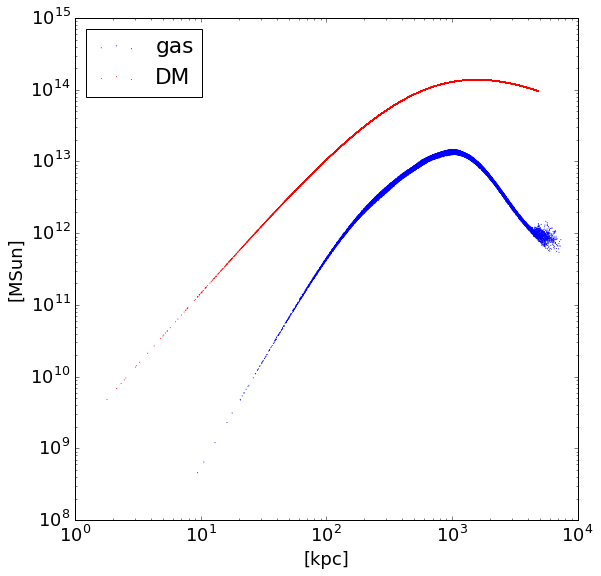

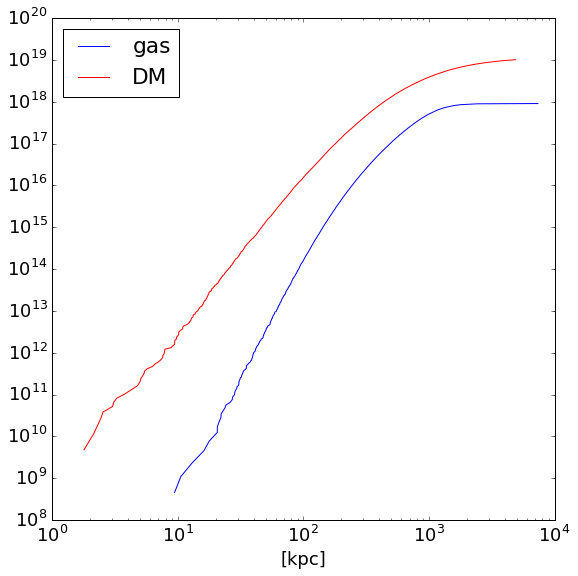

In [13]:
Mgas = (cluster.gas.density*4./3*numpy.pi*cluster.gas.r**3).as_quantity_in(units.MSun)
Mdm = (cluster.dm.density*4./3*numpy.pi*cluster.dm.r**3).as_quantity_in(units.MSun)


pyplot.figure(figsize=(9, 9))
pyplot.gca().set_xscale('log')
pyplot.gca().set_yscale('log')
amuse_plot.scatter(cluster.gas.r, Mgas, edgecolor='none', s=1, c='b', label="gas")
amuse_plot.scatter(cluster.dm.r, Mdm, edgecolor='none', s=1, c='r', label="DM")
pyplot.legend(loc=2)
pyplot.show()

radii_sort_indices = numpy.argsort(cluster.gas.r.value_in(units.kpc))
radii_sort_indices_dm = numpy.argsort(cluster.dm.r.value_in(units.kpc))
Mgas_cummulative = (Mgas[radii_sort_indices].value_in(units.MSun)).cumsum()
Mdm_cummulative = (Mdm[radii_sort_indices_dm].value_in(units.MSun)).cumsum()


pyplot.figure(figsize=(9, 9))
amuse_plot.loglog(cluster.gas.r[radii_sort_indices], Mgas_cummulative, c='b', label="gas")
amuse_plot.loglog(cluster.dm.r[radii_sort_indices_dm], Mdm_cummulative, c='r', label="DM")
pyplot.legend(loc=2)
pyplot.show()   

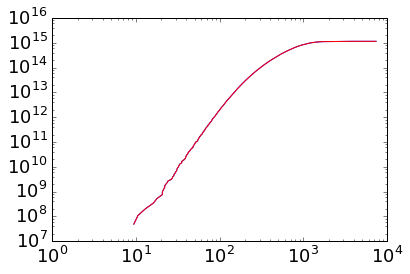

In [14]:
r = (cluster.gas.r[numpy.argsort(cluster.gas.r.value_in(units.kpc))]).value_in(units.kpc)
M = 4/3.*numpy.pi* r**2*(cluster.gas.density[numpy.argsort(cluster.gas.r.value_in(units.kpc))]).value_in(units.MSun/units.kpc**3)
# pyplot.loglog(r, M)
# pyplot.show()

# pyplot.figure()
# pyplot.loglog(r, M.cumsum())
# pyplot.show()

M_r = numpy.zeros(len(M))
M_r[0] = M[0]
for i, m in enumerate(M[:-1]):
    M_r[i+1] = M_r[i] + M[i+1]
    

pyplot.loglog(r, M_r, c='b')
pyplot.loglog(r, M.cumsum(), c='r')


Well, it's late... park the problem above for now because after a good night's sleep I might find the solution to this issue in like a second instead of spending an hour on it now :-) ...

In [15]:
# cluster = read_toycluster_into_dataset()

sph_part_mass = cluster.raw_data.massarr[0] * 1e10 | units.MSun
dm_part_mass = cluster.raw_data.massarr[1] * 1e10 | units.MSun

cluster.gas.mass = sph_part_mass
cluster.dm.mass = dm_part_mass

# Todo: we could use the code units in the converter?
converter = nbody_system.nbody_to_si(cluster.M_dm+cluster.M_gas, 1 | units.kpc)
code = Gadget2(converter, number_of_workers=4, redirection='none')

# TODO: no idea what this does, really. Just stole it from some AMUSE script.
code.parameters.epsilon_squared = 0.0000001 | nbody_system.length**2
code.parameters.time_max = 1 | units.Gyr  # because I don't particularly like errors, that's why
code_gas = code.gas_particles.add_particles(cluster.gas)
code_dm = code.dm_particles.add_particles(cluster.dm)

print "Fasten your seatbelt, this could take a while with 200000 particles on my desktop machine"

for i in range(1, 2):
    #code.evolve_model(i * (25 | units.Myr))
    #t = code.model_time.value_in(units.Myr)
    #print "Evolved model to t =", t
    # make_plots(dynamics.particles, clusters_without_halo)
    #write_set_to_file(dynamics.particles, 'particles_at_time_{0}.amuse'.format(t), 'amuse')
    #print code.particles
    print "This machine cannot evolve the code because it will probably crash the virtual machine"
code.stop()

/net/glados2.science.uva.nl/api/thalbes1/amuse-10.0/data/gadget2/output
Fasten your seatbelt, this could take a while with 200000 particles on my desktop machine
This machine cannot evolve the code because it will probably crash the virtual machine


In [16]:
whyyougivemethiserror = Gadget2(converter, number_of_workers=4)
print whyyougivemethiserror.parameters

errorthrowing_time_max = whyyougivemethiserror.parameters.time_max 

whyyougivemethiserror.stop()

/net/glados2.science.uva.nl/api/thalbes1/amuse-10.0/data/gadget2/output
artificial_viscosity_alpha: 0.5 default: 0.5
begin_time: 0.0 s default: 0.0 s
code_length_unit: 3.08567758128e+19 m default: 3.085678e+19 m
code_mass_unit: 3.16894303047e+45 kg default: 1.989e+40 kg
code_time_unit: 372706005571.0 s default: 3.085678e+16 s
code_velocity_unit: 82791195.6116 m * s**-1 default: 1000.0 m * s**-1
comoving_integration_flag: False default: False
courant: 0.3 default: 0.3
cpu_file: cpu.txt default: cpu.txt
energy_file: energy.txt default: energy.txt
eps_is_h_flag: False default: False
epsilon_squared: 9.52140613562e+34 m**2 default: 9.52140613562e+34 m**2
gadget_cell_opening_constant: 0.005 default: 0.005
gadget_cell_opening_flag: True default: True
gadget_output_directory: /net/glados2.science.uva.nl/api/thalbes1/amuse-10.0/data/gadget2/output/ default: 
gas_epsilon: 3.08567758128e+17 m default: 3.08567758128e+17 m
hubble_parameter: 0.7 default: 0.7
info_file: info.txt default: info.txt
in

/net/glados2.science.uva.nl/api/thalbes1/amuse-10.0/src/amuse/units/generic_unit_converter.py:189: RuntimeWarning: overflow encountered in double_scalars
  return new_quantity(number * factor, new_unit)


In [17]:
print errorthrowing_time_max.as_quantity_in(units.Myr)

1.18105928837 Myr


In [18]:
# ah, well, yes, indeed, quite frankly, yes, 25 Myr is somewhat larger than 1.18 Myr.
# This error is not strange then, I suppose. But why is a time_max set, and why to this seemingly arbitrary value?
# Well, whatever I'll just set it to some other value and evolve...

Time to sleep. Code is running on a dual core machine and will hopefully be done when I wake up...